In [1]:
import cv2
import csv
import json
import urllib.request
import requests
import uuid
import time
import yaml
from os import path
from pathlib import Path
from string import Template
from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
from tqdm import tqdm

In [2]:
configFile = '../pipeline/config.yml'

### Load Configuration

In [3]:
try:
    with open(configFile, 'r') as f:
        config = yaml.safe_load(f)
except:
    raise Exception("Could not load config file at", configFile)

### Define helpers

In [4]:
# Constants
SPARQL = 0
CSV = 1

def sparqlResultToDict(results):
    rows = []
    for result in results["results"]["bindings"]:
        row = {}
        for key in results["head"]["vars"]:
            if key in result:
                row[key] = result[key]["value"]
            else:
                row[key] = None
        rows.append(row)
    return rows

def writeData(data):
    try:
        with open(config['dataFile'], 'w') as f:
            writer = csv.DictWriter(f, fieldnames=['id','image','width','height','documentCoordinates'])
            writer.writeheader()
            for row in data:
                if not 'documentCoordinates' in row:
                    row['documentCoordinates'] = None
                writer.writerow(row)
    except:
        raise Exception("Could not write to", config['dataFile'])

## Step 1: Get input data

Read data from input file. This assumes that it is already fully populated with the necessary information (image sizes) as well as document coordinates.

In [5]:
inputData = []

In [6]:
try:
    with open(config['dataFile'], 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            inputData.append({
                "id": row['id'],
                "image": row['image'],
                "width": row['width'],
                "height": row['height'],
                "documentCoordinates": row['documentCoordinates'] if 'documentCoordinates' in row else None
            })
except:
    print("No prior input file found")


In [7]:
data = inputData

## Step 2: Get problematic images

Query for the images that likely have been assigned the wrong region

In [8]:
problematicImagesQuery = """

# Select images that have been assigned more than 99 similar images, indicating that the similarity has 
# been assigned based on the colour bar

PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX la: <https://linked.art/ns/terms/>
PREFIX search: <https://platform.swissartresearch.net/search/>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX crmdig: <http://www.ics.forth.gr/isl/CRMdig/>

SELECT ?id ?image WHERE {
    {
        SELECT DISTINCT ?image ?subject (COUNT(?classification) as ?num_classification) WHERE {
            ?subject crm:P128_carries/la:digitally_shown_by/la:digitally_available_via/la:access_point ?image .
            ?region crmdig:L49_is_primary_area_of ?image ;
              crm:P2_has_type <https://resource.swissartresearch.net/type/imageRegion> ;
              crm:P33_used_specific_technique <https://github.com/swiss-art-research-net/bso-image-segmentation> .
            ?classification crm:P140_assigned_attribute_to ?image ;
                crm:P33_used_specific_technique <https://github.com/swiss-art-research-net/bso-image-similarity> .
        } 
        GROUP BY ?image ?subject
    }
    FILTER(?num_classification > 99)
      ?subject a search:Object ;
        crm:P128_carries/la:digitally_shown_by/la:digitally_available_via ?iiif . 
      ?iiif dcterms:conformsTo <http://iiif.io/api/image> ;
            la:access_point ?image .
      BIND(STRAFTER(STR(?subject), "https://resource.swissartresearch.net/artwork/") as ?id)
    
} ORDER BY DESC(?num_classification) ?subject
"""

In [9]:
sparql = SPARQLWrapper(config['endpoint'], returnFormat=JSON)
sparql.setQuery(problematicImagesQuery)

In [10]:
try:
    ret = sparql.query().convert()
except:
    raise Exception("Could not execute query against endpoint", config['endpoint'])
queriedData = sparqlResultToDict(ret)

## Step 3: Select input rows with problematic coordinates

In [11]:
problematicRows = []
for row in queriedData:
    for i, inputRow in enumerate(data):
        if inputRow['id'] == row['id'] and inputRow['image'] == row['image']:
            problematicRows.append(i)

## Step 4: Detect Images

In [40]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from openCV.BSOImageCropping import BSOImageCropping
from matplotlib import pyplot as plt


  0%|          | 0/2 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 50%|█████     | 1/2 [00:00<00:00,  1.79it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[6449, 7316, 9544, 8001]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


[1606, 7569, 8940, 8530]


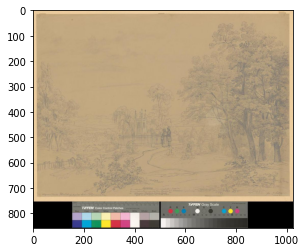

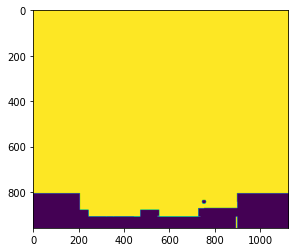

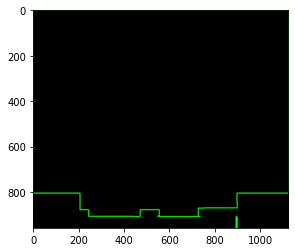

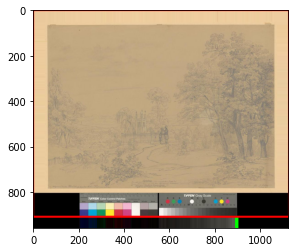

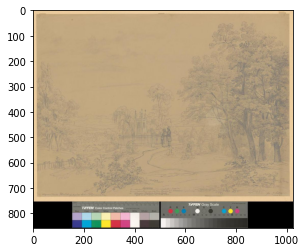

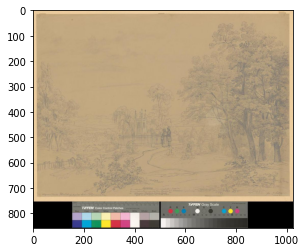

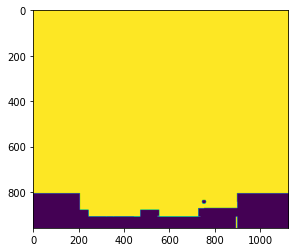

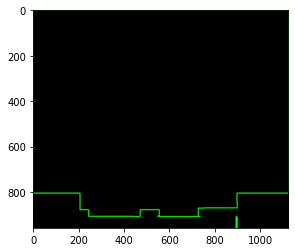

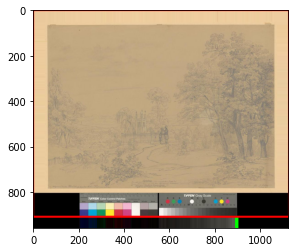

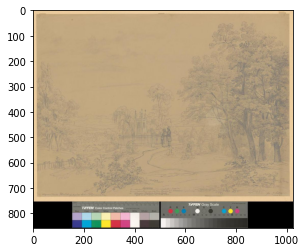

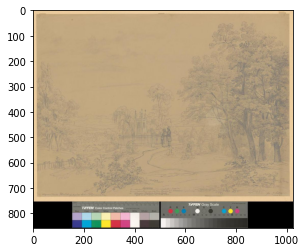

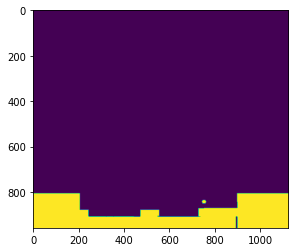

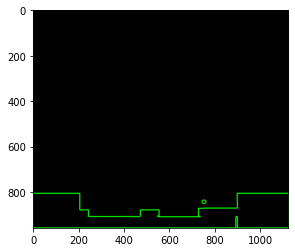

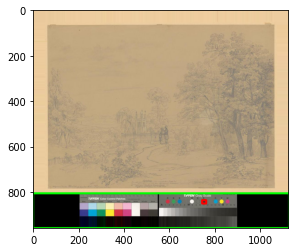

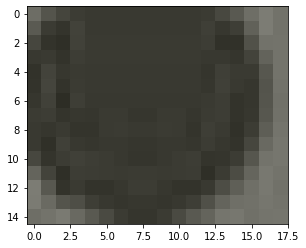

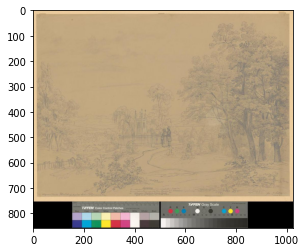

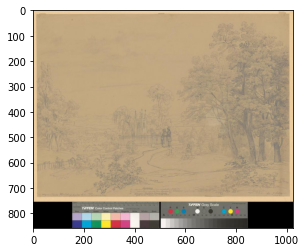

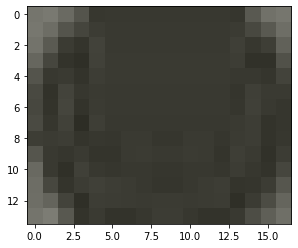

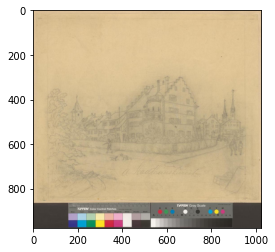

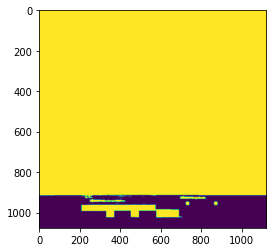

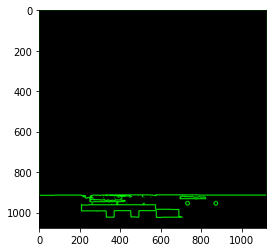

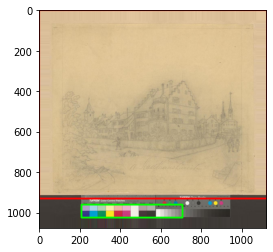

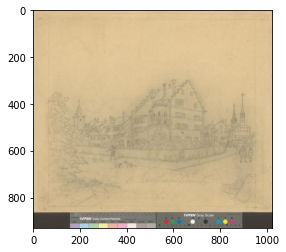

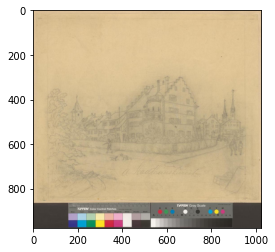

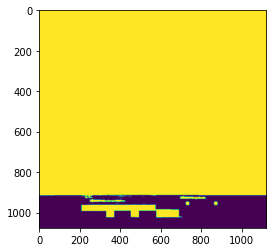

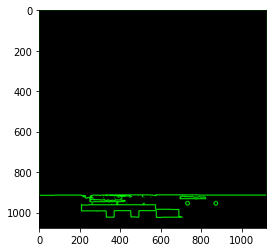

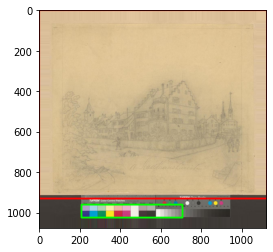

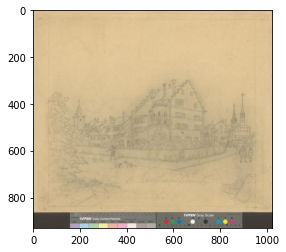

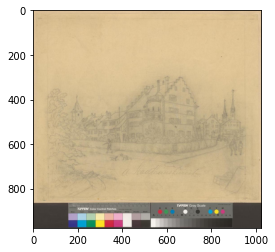

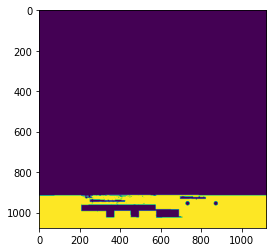

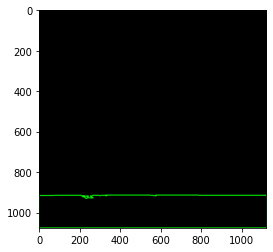

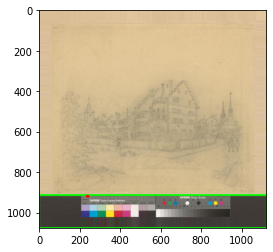

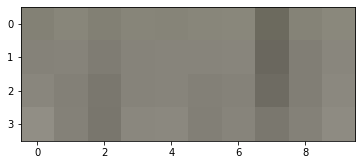

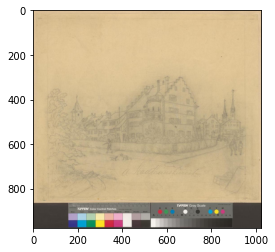

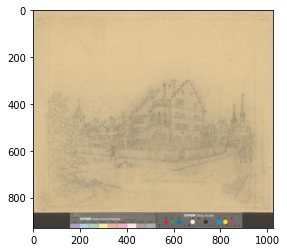

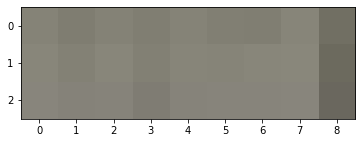

In [86]:
detector = BSOImageCropping(showImages=True)

def showImage(row):
    filename = path.join(config['imageDirectory'], row['id'] + '.jpg')
    image = cv2.imread(filename)
    image = image[:,:,::-1]
    plt.figure()
    plt.imshow(image)

def showCrop(row, coordinates):
    coordinates = [float(d) for d in coordinates.split(",")]
    filename = path.join(config['imageDirectory'], row['id'] + '.jpg')
    image = cv2.imread(filename)
    image = image[:,:,::-1]
    scaleFactor = int(row['width'])/image.shape[1]
    y0 = int(coordinates[1] / scaleFactor)
    y1 = y0 + int(coordinates[3] / scaleFactor)
    x0 = int(coordinates[0] / scaleFactor)
    x1 = x0 + int(coordinates[2] / scaleFactor)
    croppedImage = image.copy()[y0:y1, x0:x1]
    plt.figure()
    plt.imshow(croppedImage)

def getDocumentCoordinates(row, mode=0):
    filename = path.join(config['imageDirectory'], row['id'] + '.jpg')
    if path.isfile(filename):
        image = cv2.imread(filename)
        image = image[:,:,::-1]

        if mode == 0:
            x,y,w,h = detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_LARGEST)
        elif mode == 1:
            x,y,w,h = detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_SQUAREST)
        elif mode == 2:
            x,y,w,h = detector.cropImage(image, invertImage=True, selectMethod=BSOImageCropping.SELECT_SQUAREST)
        elif mode == 3:
            x,y,w,h = detector.cropImage(image, invertImage=True, selectMethod=BSOImageCropping.SELECT_LARGEST)

        # Upscale to original size
        scaleFactor = int(row['width'])/image.shape[1]
        documentCoordinates = "%d,%d,%d,%d" % (int( x * scaleFactor),
                                                      int( y * scaleFactor),
                                                      int( w * scaleFactor),
                                                      int( h * scaleFactor))
        return documentCoordinates
    else:
        print("Could not open", filename)
        return False
    
def correctDocumentCoordinates(row, documentCoordinates):
    coordinates = [int(d) for d in documentCoordinates.split(",")]
    width, height = int(row['width']), int(row['height'])
    coordinates[2] = max(int(coordinates[2]-width/100), width)
    coordinates[3] = max(int(coordinates[3]-height/100), height)
    if coordinates == [0, 0, width, height]:
        # Region covers entire image or is too small
        # Return adjusted regions that excludes previous (problematic)
        # region at the top or bottom
        regionY = int(row['documentCoordinates'].split(",")[1])
        regionHeight = int(row['documentCoordinates'].split(",")[3])
        if regionY > height:
            return ','.join(["0", "0", str(width), str(regionY)])
        else:
            return ','.join(["0", str(regionHeight), str(width), str(height-regionHeight)])

    return documentCoordinates
    
for index in tqdm(problematicRows[29:31]):
    row = data[index]
    
    numModes = 4
    
    for mode in range(0, numModes):
        documentCoordinates = getDocumentCoordinates(row, mode)
        if not documentCoordinates == row['documentCoordinates']:
            break
        
    documentCoordinates = correctDocumentCoordinates(row, documentCoordinates)
    
    showImage(row)
    showCrop(row, row['documentCoordinates'])
    showCrop(row, documentCoordinates)
    # Store coordinates in data after every prediction
    #writeData(data)

## Step 5: Validate image regions

Do some automatised quality control. Check if the image regions detected exceed a certain size. If not, try again with a different strategy. If they are still too small, discard the result.

In [14]:
minSizeRatio = 0.1 # Detected region should cover at least x% of width or height

In [15]:
toCheck = []
for row in data:
    if row['documentCoordinates']:
        boundingBox = row['documentCoordinates'].split(",")
        boxWidth = int(boundingBox[2])
        boxHeight = int(boundingBox[3])+1      
        imageWidth = int(row['width'])
        imageHeight = int(row['height'])
        if boxWidth / imageWidth < minSizeRatio or boxHeight / imageHeight < minSizeRatio:
            toCheck.append(row)    

In [16]:
print("Found %d image crops that might be too small" % len(toCheck))

Found 471 image crops that might be too small


In [17]:
recalculated = []
discarded = []

for row in tqdm(toCheck):    
    filename = path.join(config['imageDirectory'], row['id'] + '.jpg')
    if path.isfile(filename):
        image = cv2.imread(filename)
        image = image[:,:,::-1]
        # Try again with largest strategy
        x,y,w,h = detector.cropImage(image, selectMethod=BSOImageCropping.SELECT_LARGEST)
        if w / image.shape[1] > minSizeRatio and h / image.shape[2] > minSizeRatio:
            scaleFactor = int(row['width'])/image.shape[1]
            row['documentCoordinates'] = "%d,%d,%d,%d" % (int( x * scaleFactor),
                                                          int( y * scaleFactor),
                                                          int( w * scaleFactor),
                                                          int( h * scaleFactor))
            recalculated.append(row)
        else:
            row['documentCoordinates'] = None
            discarded.append(row)

100%|██████████| 471/471 [00:14<00:00, 31.93it/s]


In [18]:
print("Recalculated %d image regions" % len (recalculated))
print("Discarded %d image regions" % len (discarded))

Recalculated 456 image regions
Discarded 15 image regions


## Step 6: Output as CIDOC-CRM RDF

Output as a Trig file that can be displayed and edited in the Mirador component of ResearchSpace & Metaphacts

In [19]:
namespaces = """
PREFIX Platform: <http://www.metaphacts.com/ontologies/platform#> 
PREFIX User: <http://www.metaphacts.com/resource/user/> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 
PREFIX crmdig: <http://www.ics.forth.gr/isl/CRMdig/> 
PREFIX rso: <http://www.researchspace.org/ontology/> 
PREFIX prov: <http://www.w3.org/ns/prov#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX ldp: <http://www.w3.org/ns/ldp#> 
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
"""

static = """

<https://platform.swissartresearch.net/imageRegions> {
    <https://resource.swissartresearch.net/type/imageRegion> a crm:E55_Type ;
    rdfs:label "Image Region" ;
    crm:P3_has_note "A region defining the visual image represented within a digital image. For example, the region denotes the visual item that is reproduced on a document which is photographed.".
}
"""

regionTemplate = Template('''<$uri/container/context> {
  Platform:formContainer ldp:contains <$uri/container> .
  
  <$uri>
    a crmdig:D35_Area, rso:EX_Digital_Image_Region;
    crmdig:L49_is_primary_area_of <$iiifImage>;
    crm:P33_used_specific_technique <https://github.com/swiss-art-research-net/bso-image-segmentation> ;
    rso:boundingBox "xywh=$x,$y,$w,$h";
    rso:displayLabel "image";
    rso:viewport "xywh=0,0,0,0";
    rdf:value "<svg xmlns='http://www.w3.org/2000/svg'><path xmlns=\\"http://www.w3.org/2000/svg\\" d=\\"M${x0},${y0}l${halfW},0l0,0l${halfW},0l 0,${halfH}l 0,${halfH}l -${halfW},0l -${halfW},0l 0,-${halfH}z\\" data-paper-data=\\"{&quot;defaultStrokeValue&quot;:1,&quot;editStrokeValue&quot;:5,&quot;currentStrokeValue&quot;:1,&quot;rotation&quot;:0,&quot;deleteIcon&quot;:null,&quot;rotationIcon&quot;:null,&quot;group&quot;:null,&quot;editable&quot;:true,&quot;annotation&quot;:null}\\" id=\\"rectangle_e880ad36-1fef-4ce3-835d-716ba7db628a\\" fill-opacity=\\"0\\" fill=\\"#00bfff\\" fill-rule=\\"nonzero\\" stroke=\\"#00bfff\\" stroke-width=\\"4.04992\\" stroke-linecap=\\"butt\\" stroke-linejoin=\\"miter\\" stroke-miterlimit=\\"10\\" stroke-dasharray=\\"\\" stroke-dashoffset=\\"0\\" font-family=\\"none\\" font-weight=\\"none\\" font-size=\\"none\\" text-anchor=\\"none\\" style=\\"mix-blend-mode: normal\\"/></svg>" .
  
  <$uri/container>
    a ldp:Resource, prov:Entity;
    prov:generatedAtTime "$dateTime"^^xsd:dateTime;
    prov:wasAttributedTo User:admin .
}

<https://platform.swissartresearch.net/imageRegions> {
    <$uri> crm:P2_has_type <https://resource.swissartresearch.net/type/imageRegion> .
}

''')

In [20]:
dateTime = datetime.now().strftime("%Y-%m-%dT%H:%M:%S+00:00z")

output = namespaces + static

missingDocumentCoordinates = []

for row in tqdm(data):
    if row['documentCoordinates'] is None:
        missingDocumentCoordinates.append(row)
        continue
        
    docCoords = row['documentCoordinates'].split(',')
    
    if len(docCoords) < 4:
        missingDocumentCoordinates.append(row)
        continue

    x = int(docCoords[0])
    y = int(docCoords[1])
    w = int(docCoords[2])
    h = int(docCoords[3])

    edges = {
        "topLeft": (x, y),
        "topRight": (x + w, y),
        "bottomRight": (x + w, y + h),
        "bottomLeft": (x, y + h)
    }
    iiifImage = row['image']
    identifier = str(uuid.uuid3(uuid.NAMESPACE_DNS, iiifImage))
    uri = "https://resource.swissartresearch.net/digitalobject/" + identifier
    x0 = edges['topLeft'][0]
    y0 = edges['topLeft'][1]
    x1 = edges['bottomRight'][0]
    y1 = edges['bottomRight'][1]
    x = x0
    y = y0
    w = x1 - x0
    h = y1 - y0
    output += regionTemplate.substitute(
        uri=uri,
        iiifImage=iiifImage,
        x=int(x),
        y=int(y),
        w=int(w),
        h=int(h),
        x0=x0,
        y0=y0,
        halfW=float(w/2),
        halfH=float(h/2),
        dateTime=dateTime
    )

# Write summary of missing corodinates
if len(missingDocumentCoordinates) > 0:
    print("Could not detect coordinates in %d images:" % len(missingDocumentCoordinates))
    print('\n'.join([d['id'] for d in missingDocumentCoordinates]))
    
filename = path.join(config['trigFile'])
with open(filename, 'w') as f:
    f.write(output)

100%|██████████| 28103/28103 [00:01<00:00, 20612.48it/s]


Could not detect coordinates in 47 images:
zbz-990099678450205508
zbz-990100190680205508
zbz-990100842470205508
zbz-990101003860205508
zbz-990101237540205508
zbz-990101242490205508
zbz-990101296780205508
zbz-990101594940205508
zbz-990101633300205508
zbz-990101633600205508
zbz-990101910140205508
zbz-990101911400205508
nb-1050431
nb-812808
nb-815037
nb-815050
nb-815054
nb-815062
nb-815093
nb-815097
nb-815102
nb-815125
nb-815670
nb-822350
nb-838092
nb-838152
nb-838155
nb-838157
nb-838160
nb-838162
nb-838164
nb-838166
nb-838168
nb-838170
nb-838172
nb-838174
nb-838176
nb-838178
nb-838180
nb-838182
nb-841831
nb-841890
nb-861242
nb-870419
nb-870422
nb-894459
nb-919292
